# LSTM (Long Short Term Memory) model for population forcasting
Used for gap filling in this case

In [214]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import math
import matplotlib.pyplot as plt

## Upload data

In [215]:
data = pd.read_csv('CompleteData.csv')
data.head()

,index,indic_code,urau_code,1991,1992,1993,1994,1995,1996,1997,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,7,DE1001V,BE,9986975.0,10021997.0,10068319.0,10100631.0,10130574.0,10143047.0,10170226.0,...,11094850.0,11161642.0,11203992.0,11258434.0,11307192.0,11351727.0,11398589.0,11455519.0,11522440.0,11554767.0
1,8,DE1001V,BE001C,954045.0,951217.0,950339.0,949070.0,951580.0,948122.0,950597.0,...,1159448.0,1174624.0,1183841.0,1196831.0,1201129.0,1199095.0,1205492.0,1215289.0,1223364.0,1226329.0
2,9,DE1001V,BE002C,467518.0,465783.0,465102.0,462880.0,459072.0,455852.0,453030.0,...,507368.0,512230.0,513915.0,515593.0,517731.0,520859.0,523591.0,526439.0,530014.0,530627.0
3,10,DE1001V,BE003C,230246.0,230232.0,229821.0,228490.0,227483.0,226464.0,225469.0,...,249205.0,249754.0,251984.0,253914.0,257226.0,259462.0,260329.0,262205.0,263687.0,264019.0
4,11,DE1001V,BE004C,206214.0,206903.0,207045.0,206898.0,206491.0,205591.0,204899.0,...,204762.0,204826.0,203640.0,203228.0,202602.0,201884.0,202341.0,202637.0,203314.0,238412.0


## Select one country/city 

In [216]:
city_index = 13
population_timeSeries = data.iloc[city_index]

## Drop non relevant columns + reshape

In [217]:
population_timeSeries= population_timeSeries.drop(['index', 'indic_code', 'urau_code'])
population_data = population_timeSeries.values.reshape(-1, 1)

## Normalize the data to a range of (0, 1)


In [218]:
scaler = MinMaxScaler(feature_range=(0, 1))
population_data_scaled = scaler.fit_transform(population_data)

## Split the data into training and testing sets

In [219]:
train_size = int(len(population_data_scaled) * 0.7)  # 70% for training, 30% for testing
train_data, test_data = population_data_scaled[:train_size], population_data_scaled[train_size:]

## Create sequences for training/testing

In [220]:
# Function to create input sequences and corresponding outputs for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [221]:
# Define the sequence length (number of time steps to look back)
sequence_length = 3
# Create sequences for LSTM
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape the input data for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [222]:
## Create the LSTM model

In [223]:
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, 1)))  # 50 LSTM units
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer with 1 unit
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# Print model summary
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 50)                10400     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None


## Train the model

In [224]:
epochs = 100
batch_size = 4
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/100
5/5 [==============================] - 3s 5ms/step - loss: 0.1081
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0793
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0549
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0209
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0136
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0074
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0082
Epoch 9/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0057
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0083
Epoch 11/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 12/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 13/100
5/5 [==============================] - 0s 3ms/st

In [225]:
## Evaluate the model on both the training and testing data

In [226]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Inverse transform the predictions to get actual population values
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate and print the Mean Absolute Percentage Error (MAPE) and RMSE
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100
rmse = math.sqrt(np.mean(np.abs((y_test_actual - y_pred_actual)**2)))

print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

print(f'Root Mean Squared Percentage Error (RMSE): {rmse:.2f}')

1/1 [==============================] - 1s 761ms/step
Mean Absolute Percentage Error (MAPE): 0.42%
Root Mean Squared Percentage Error (RMSE): 1348.01


In [227]:
# Make predictions on the training data
y_pred_train = model.predict(X_train)
y_pred_train_actual = scaler.inverse_transform(y_pred_train)
y_train_actual = scaler.inverse_transform(y_train)

1/1 [==============================] - 0s 47ms/step


## Plot actual and predicted time series

### On Training data

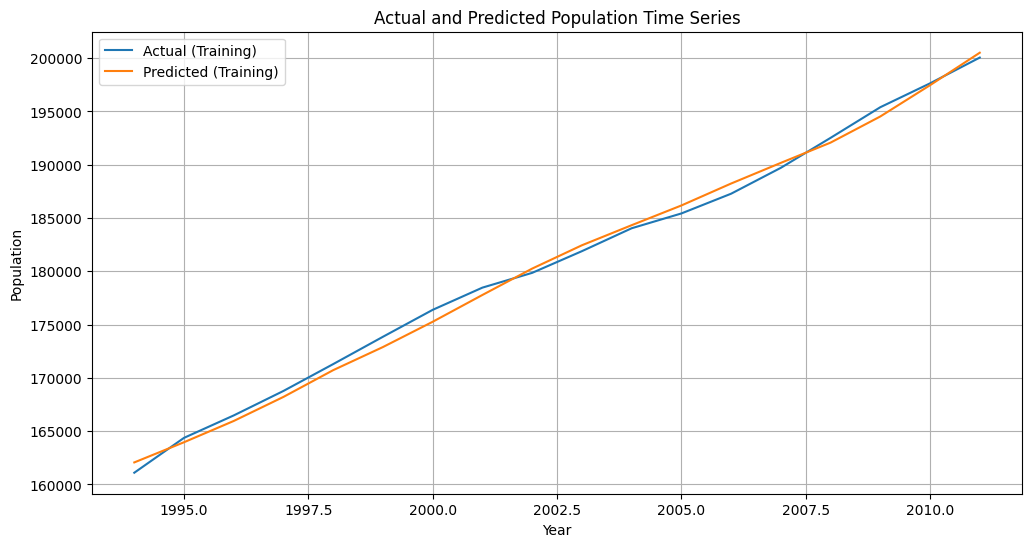

In [211]:
x = range(1991, 2022)
plt.figure(figsize=(12, 6))

plt.plot(x[sequence_length:train_size], y_train_actual, label='Actual (Training)')
plt.plot(x[sequence_length:train_size], y_pred_train_actual, label='Predicted (Training)')

plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Actual and Predicted Population Time Series')
plt.legend()
plt.grid(True)
plt.show()

### On Testing data

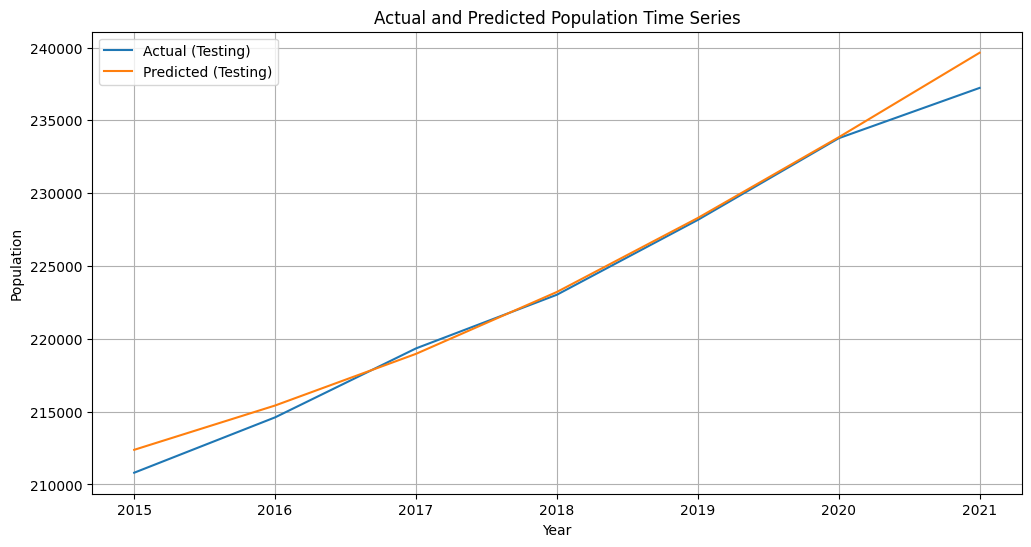

In [213]:
plt.figure(figsize=(12, 6))

plt.plot(x[train_size+sequence_length:], y_test_actual, label='Actual (Testing)')
plt.plot(x[train_size+sequence_length:], y_pred_actual, label='Predicted (Testing)')

plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Actual and Predicted Population Time Series')
plt.legend()
plt.grid(True)
plt.show()